# <img src="./resources/GA.png" width="25" height="25" />   <span style="color:Purple">Project 5 :  Food Insecurity Regression Study</span> 
---
## <span style="color:Green">Preprocessing / Modeling</span>      

#### Alec Edgecliffe-Johnson, Ryan McDonald, Andrew Roberts, Ira Seidman- General Assembly 



---

### Notebook Contents:

- [Reading the Data](#intro)
- [Modeling](#modeling)
    - [Production Model, LinReg](#prod)
         - [Extended Analysis](#analysis)
    - [Model #2, KNN](#second)
    - [Model #3, Decision Tree](#third)
    - [Model #4, PolyFeat, LinReg](#fourth)
    - [Model #5, ADA Boost](#fifth)
    - [Model #6, SVM](#sixth)
    - [Model #7, TF NN](#seventh)


**Imports**

In [1]:
import pandas as pd
import numpy as np

# Plotting Imports
import matplotlib.pyplot as plt
import seaborn as sns

# SciKit Learn Processing/ Modeling Imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Tensor Flow, Keras NN
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model


<a id='intro'></a>

## 1. Read the Data

In [3]:
df = pd.read_csv('data/df_final.csv')

<a id='modeling'></a>
## Modeling Pre-work

**Setting X, y and Train-Test-Split**

In [4]:
features = df.drop(columns = ['ch_fi_rate_18', 'fi_rate_18', 'cpm_18', 
                       'state_abr', 'state_name', 'fips', 'county'])

X = features
y = df['fi_rate_18']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)

In [5]:
# Scaling Data
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

<a id='prod'></a>
### Model 1: Production Model

**Linear Regression**

In [21]:
LinearRegression().get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize'])

In [31]:
# Setting up the Pipeline/ GridSearch

pipe_ln = Pipeline([
    ('ln', LinearRegression())
])

pipe_ln_params = { 'ln__fit_intercept': [False, True],
                  'ln__copy_X': [False, True],
                  'ln__normalize': [False, True]
}

pipe_ln.fit(Z_train, y_train)
gs_ln = GridSearchCV(pipe_ln, 
                        param_grid = pipe_ln_params, 
                        cv=5)

gs_ln.fit(Z_train, y_train);

In [23]:
print(gs_ln.best_score_)
gs_ln.best_params_

0.9331071494649233


{'ln__copy_X': False, 'ln__fit_intercept': True, 'ln__normalize': False}

In [24]:
ln_preds_train = gs_ln.predict(Z_train)
ln_preds_test = gs_ln.predict(Z_test)

print(f'ln Training RMSE: {mean_squared_error(y_train, ln_preds_train, squared = False)}')
print(f'ln Testing RMSE: {mean_squared_error(y_test, ln_preds_test, squared = False)}')

ln Training RMSE: 0.9242882324129449
ln Testing RMSE: 0.9967000195040715


In [25]:
print(f'Training R2: {pipe_ln.score(Z_train, y_train)}')
print(f'Testing R2: {pipe_ln.score(Z_test, y_test)}')

Training R2: 0.9386462698301442
Testing R2: 0.9330074240127388


In [26]:
feature_names = features
coefs_ln = pipe_ln.named_steps['ln'].coef_.flatten()
model_zip = zip(feature_names, coefs_ln)
model_zip_df = pd.DataFrame(model_zip, columns = ['features', 'coefficients'])
model_zip_df.sort_values(by = 'coefficients', ascending = False).head(10)

,features,coefficients
44,percent_disabled,0.767051
16,percent_children_in_poverty,0.552381
5,percent_fair_or_poor_health,0.470569
28,percent_severe_housing_cost_burden,0.334582
20,percent_severe_housing_problems,0.288251
39,percent_below_poverty,0.192885
18,percent_single_parent_households_CHR,0.174937
17,num_households_CHR,0.161619
40,percent_unemployed_CDC,0.151693
43,percent_age_17_and_younger,0.143348


<a id='analysis'></a>
### Production Model Analysis 

<a id='second'></a>
### Model 2: KNN

In [28]:
KNeighborsRegressor().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [32]:
# Setting up the Pipeline/ GridSearch

pipe_knn = Pipeline([
    ('knn', KNeighborsRegressor())
])

pipe_knn_params = { 'knn__n_neighbors': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            }

pipe_knn.fit(Z_train, y_train)
gs_knn = GridSearchCV(pipe_knn, 
                        param_grid = pipe_knn_params, 
                        cv=5)

gs_knn.fit(Z_train, y_train);

In [33]:
print(gs_knn.best_score_)
gs_knn.best_params_

0.851301455655712


{'knn__n_neighbors': 5}

In [34]:
knn_preds_train = gs_knn.predict(Z_train)
knn_preds_test = gs_knn.predict(Z_test)

print(f'knn Training RMSE: {mean_squared_error(y_train, knn_preds_train, squared = False)}')
print(f'knn Testing RMSE: {mean_squared_error(y_test, knn_preds_test, squared = False)}')

knn Training RMSE: 1.1430855549727068
knn Testing RMSE: 1.4479205383412166


In [35]:
print(f'Training R2: {pipe_knn.score(Z_train, y_train)}')
print(f'Testing R2: {pipe_knn.score(Z_test, y_test)}')

Training R2: 0.9061609510423924
Testing R2: 0.8586202527205257


**Quick Analysis**

<a id='third'></a>
### Model 3: Decision Tree

In [36]:
DecisionTreeRegressor().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [37]:
DecisionTreeRegressor().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [94]:
# Setting up the Pipeline/ GridSearch
pipe_dt = Pipeline([
    ('dt', DecisionTreeRegressor())
])

pipe_dt_params = {'dt__max_depth': [5, 10, None], 
                  'dt__max_features': ['auto', 'log2'], 
                'dt__max_depth': [2,4,6,8,10,12]
                 }

pipe_dt.fit(Z_train, y_train)
gs_dt = GridSearchCV(pipe_dt, 
                        param_grid = pipe_dt_params, 
                        cv=5)

gs_dt.fit(Z_train, y_train);

In [53]:
print(gs_dt.best_score_)
gs_dt.best_params_

0.7869780193745138


{'dt__max_depth': 6, 'dt__max_features': 'auto'}

In [54]:
dt_preds_train = gs_dt.predict(Z_train)
dt_preds_test = gs_dt.predict(Z_test)

print(f'dt Training RMSE: {mean_squared_error(y_train, knn_preds_train, squared = False)}')
print(f'dt Testing RMSE: {mean_squared_error(y_test, knn_preds_test, squared = False)}')

dt Training RMSE: 1.1430855549727068
dt Testing RMSE: 1.4479205383412166


In [55]:
print(f'Training R2: {pipe_dt.score(Z_train, y_train)}')
print(f'Testing R2: {pipe_dt.score(Z_test, y_test)}')

Training R2: 1.0
Testing R2: 0.7747778596742375


**Quick Analysis**

<a id='fourth'></a>
### Model 4: PolynomialFeatures with StandardScalar and Linear Regression

In [58]:
features = ['percent_children_in_poverty', 'percent_below_poverty', 'percent_fair_or_poor_health',
            'pct_overall_pov_19','percentile_rank_social_vulnerability']

X = df[features]
y = df['fi_rate_18']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)
pf = PolynomialFeatures(degree=2)
X_train_pf = pf.fit_transform(X_train)
X_test_pf = pf.transform(X_test)




In [59]:
LinearRegression().get_params().keys(), PolynomialFeatures().get_params().keys()

(dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize']),
 dict_keys(['degree', 'include_bias', 'interaction_only', 'order']))

In [60]:
# Setting up the Pipeline/ GridSearch
pipe_ln = Pipeline([
    ('ss', StandardScaler()),
    ('ln', LinearRegression()),
#     ('model', LassoCV())
])
pipe_ln_params = {'ln__normalize':[True, False],
                  'ln__fit_intercept':[True, False]
#                   'model__alpha':[0.001, 0.01, 0.1],
#                   'model__max_iter':[1000, 2000],
#                   'model__normalize':[True, False]
                  }

pipe_ln.fit(X_train_pf, y_train)
gs_ln = GridSearchCV(pipe_ln, 
                        param_grid = pipe_ln_params, 
                        cv=5)

gs_ln.fit(X_train_pf, y_train);

ln_preds_train = gs_ln.predict(X_train_pf)
ln_preds_test = gs_ln.predict(X_test_pf)
print(f'ln Training RMSE: {mean_squared_error(y_train, ln_preds_train, squared = False)}')
print(f'ln Testing RMSE: {mean_squared_error(y_test, ln_preds_test, squared = False)}')
print(f'Training R2: {pipe_ln.score(X_train_pf, y_train)}')
print(f'Testing R2: {pipe_ln.score(X_test_pf, y_test)}')

feature_names = features
coefs_ln = pipe_ln.named_steps['ln'].coef_.flatten()
model_zip = zip(feature_names, coefs_ln)
model_zip_df = pd.DataFrame(model_zip, columns = ['features', 'coefficients'])
model_zip_df.sort_values(by = 'coefficients', ascending = False)

ln Training RMSE: 1.652341472472501
ln Testing RMSE: 1.692077560336421
Training R2: 0.8039234164197737
Testing R2: 0.8069195616440654


,features,coefficients
3,pct_overall_pov_19,2.285601
1,percent_below_poverty,1.365929
4,percentile_rank_social_vulnerability,0.095530
2,percent_fair_or_poor_health,0.051696
0,percent_children_in_poverty,0.000000


In [61]:
print(gs_ln.best_score_)
gs_ln.best_params_

0.7976139661653221


{'ln__fit_intercept': True, 'ln__normalize': True}

**Will Lasso Improve our Score?**

In [64]:
lasso=LassoCV(max_iter=15000 )
lasso.fit(X_train_pf, y_train)

LassoCV(max_iter=15000)

In [65]:
print(f"Lasso CV Training R=Squared: {lasso.score(X_train_pf, y_train)}")
print(f"Lasso CV Testing R=Squared: {lasso.score(X_test_pf, y_test)}")

Lasso CV Training R=Squared: 0.7573510458114212
Lasso CV Testing R=Squared: 0.7827335296909608


**Quick Analysis**

<a id='fifth'></a>
### Model 5: ADA Boost

In [67]:
features = df.drop(columns = ['ch_fi_rate_18', 'fi_rate_18', 'cpm_18', 
                       'state_abr', 'state_name', 'fips', 'county'])



#### Setting Feature and Target Variables
**Scaling and Train-Test-Split**

In [68]:
X = features
y = df['fi_rate_18']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)

ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [69]:
# random seed for the rest of the notebook
np.random.seed(42)

In [70]:
AdaBoostRegressor().get_params().keys()


dict_keys(['base_estimator', 'learning_rate', 'loss', 'n_estimators', 'random_state'])

In [71]:
pipe_ada = Pipeline([
    ('ada', AdaBoostRegressor())
])


In [72]:
# https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781787286382/9/ch09lvl1sec95/tuning-an-adaboost-regressor
pipe_ada_params = {  
 'ada__n_estimators': [100, 150, 200],
 'ada__learning_rate' : [1, 5, 10],
 'ada__loss' : ['linear', 'square', 'exponential']
}


In [73]:
pipe_ada.fit(Z_train, y_train)
gs_ada = GridSearchCV(pipe_ada, 
                        param_grid = pipe_ada_params, 
                        cv=5)

In [77]:
print(gs_ada.best_params_)

{'ada__learning_rate': 1, 'ada__loss': 'square', 'ada__n_estimators': 200}


In [78]:
gs_ada.fit(Z_train, y_train);

In [79]:
ada_preds_train = gs_ada.predict(Z_train)
ada_preds_test = gs_ada.predict(Z_test)

In [80]:
print(f'AdaBoost Training RMSE: {mean_squared_error(y_train, ada_preds_train, squared = False)}')
print(f'AdaBoost Testing RMSE: {mean_squared_error(y_test, ada_preds_test, squared = False)}')
print(f'Training R2: {pipe_ada.score(Z_train, y_train)}')
print(f'Testing R2: {pipe_ada.score(Z_test, y_test)}')

AdaBoost Training RMSE: 1.2773228209775374
AdaBoost Testing RMSE: 1.452327363310606
Training R2: 0.8748507243766415
Testing R2: 0.846666164902464


In [81]:
feature_names = features
coefs_ada = pipe_ada.named_steps['ada'].feature_importances_
model_zip = zip(feature_names, coefs_ada)
model_zip_df = pd.DataFrame(model_zip, columns = ['features', 'coefficients'])
model_zip_df.sort_values(by = 'coefficients', ascending = False).head(10)

,features,coefficients
16,percent_children_in_poverty,0.193044
39,percent_below_poverty,0.151260
48,pct_overall_pov_19,0.133538
22,life_expectancy,0.075478
25,median_household_income,0.062817
47,percentile_rank_social_vulnerability,0.058584
6,average_number_of_mentally_unhealthy_days,0.058199
44,percent_disabled,0.048597
5,percent_fair_or_poor_health,0.039349
40,percent_unemployed_CDC,0.036158


**Quick Analysis**

<a id='sixth'></a>
### Model 6: Support Vector Machines

In [23]:
SVR().get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [87]:
# Setting up Pipeling and GridSearch
pipe_svr = Pipeline([
    ('svr', SVR(kernel='linear'))
])


pipe_svr_params = {  
 'svr__C': [.01, .1, 1, 10, 100]
}


pipe_svr.fit(Z_train, y_train)
gs_svr = GridSearchCV(pipe_svr, 
                        param_grid = pipe_svr_params, 
                        cv=5,
                        n_jobs=4
)

In [88]:
gs_svr.fit(Z_train, y_train);

In [89]:
svr_preds_train = gs_svr.predict(Z_train)
svr_preds_test = gs_svr.predict(Z_test)

In [90]:
print(f'SVR Training RMSE: {mean_squared_error(y_train, svr_preds_train, squared = False)}')
print(f'SVR Testing RMSE: {mean_squared_error(y_test, svr_preds_test, squared = False)}')
print(f'Training R2: {pipe_svr.score(Z_train, y_train)}')
print(f'Testing R2: {pipe_svr.score(Z_test, y_test)}')

SVR Training RMSE: 0.9366578780068757
SVR Testing RMSE: 1.0006495337045944
Training R2: 0.9369931011152008
Testing R2: 0.9324754437734858


In [93]:
# attribute error associated with coefficents. Can't get coefficents, but since we are seeking accuracy over interpretability then that is OK.

feature_names = features
coefs_svr = pipe_svr.named_steps['svr'].coef_
model_zip = zip(feature_names, coefs_svr)
model_zip_df = pd.DataFrame(model_zip, columns = ['features', 'coefficients'])
model_zip_df.sort_values(by = 'coefficients', ascending = False)

,features,coefficients
0,lat,"[-0.09500268194691941, 0.0772224931192671, -0.014253348458105108, 0.03745356823913326, 0.052440934151810836, 0.5180078169045643, 0.1416306703463981, 0.14468979679552696, -0.012546599994928798, 0.06713975914042791, -3.7580612295956115, 0.048092961344494256, 0.04177971424301852, 0.15416030270655412, 0.039294403618672646, -0.05091340760771246, 0.5870801435946982, 0.03757776877539598, 0.2117905914182785, -0.14392124768969694, 0.3319907475937356, -0.5844828096041823, -0.10439769066995197, 0.050044025360961086, -2.453014102692862, -0.05827058903630267, -0.14594184279148337, 0.08039420776725947, 0.25772401259429145, -0.8685884039454379, -0.3372026223509952, -0.031491387111373115, 0.0389980182714007, 0.0256545867496607, 0.21795956150827145, -0.037170137324244124, -0.0437330207670108, 0.0860010465387262, 0.029882224778358335, 0.13898011902101004, 0.13922389576088, -0.20061017897080546, -0.08966947551140692, 0.14212780832455962, 0.7487627440467719, 0.31101864715489924, 0.1368048635809611, -0.0559836936898499, -0.20513823247270935, 0.16847325423994874, -0.2119712351902443, 0.05897082147129851, -0.048334020328343996]"


**Quick Analysis**

<a id='seventh'></a>
### Model 7: TensorFlow NN

In [16]:
features = df.drop(columns = ['ch_fi_rate_18', 'fi_rate_18', 'cpm_18', 
                       'state_abr', 'state_name', 'fips', 'county'])

X = features
y = df['fi_rate_18']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)

# Scaling Data
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

rmse = RootMeanSquaredError()

In [25]:
model = Sequential()

model.add(Dense(64, input_shape = (Z_train.shape[1], ),
                  activation = 'relu',
                  ))

model.add(BatchNormalization())   # BatchNormalization layer added from Part 7

model.add(Dense(128, activation = 'relu', 
                  kernel_regularizer = l2(0.01)
                  )) # Second hidden layer
model.add(Dropout(0.05))  # Dropout layer 5 % to 2nd layer

model.add(Dense(64, activation = 'relu', 
                  kernel_regularizer = l2(0.01)
                  )) # Third hidden layer
model.add(Dropout(0.20))  # Dropout layer 20 % to 3rd layer

# Add output layer

model.add(Dense(1, activation = None)) 

# Compile it
model.compile(loss = 'mse' ,optimizer = 'adam', metrics= [rmse,'mse'])                                     
# early_stop object


early_stop = EarlyStopping(patience=5)

# Fit it
results_es = model.fit(Z_train, y_train,
            validation_data= (Z_test, y_test),
            epochs = 50, 
            verbose = 2,
            callbacks = [early_stop])

Epoch 1/50
74/74 - 1s - loss: 54.2499 - root_mean_squared_error: 6.2987 - mse: 52.4582 - val_loss: 48.7192 - val_root_mean_squared_error: 6.8472 - val_mse: 46.8836
Epoch 2/50
74/74 - 0s - loss: 8.8213 - root_mean_squared_error: 2.6467 - mse: 7.0051 - val_loss: 21.4117 - val_root_mean_squared_error: 4.4291 - val_mse: 19.6171
Epoch 3/50
74/74 - 0s - loss: 7.6071 - root_mean_squared_error: 2.4150 - mse: 5.8321 - val_loss: 8.8536 - val_root_mean_squared_error: 2.6643 - val_mse: 7.0983
Epoch 4/50
74/74 - 0s - loss: 7.5334 - root_mean_squared_error: 2.4089 - mse: 5.8028 - val_loss: 7.0580 - val_root_mean_squared_error: 2.3137 - val_mse: 5.3533
Epoch 5/50
74/74 - 0s - loss: 7.0444 - root_mean_squared_error: 2.3142 - mse: 5.3557 - val_loss: 4.5727 - val_root_mean_squared_error: 1.7037 - val_mse: 2.9026
Epoch 6/50
74/74 - 0s - loss: 6.5731 - root_mean_squared_error: 2.2193 - mse: 4.9255 - val_loss: 5.3272 - val_root_mean_squared_error: 1.9252 - val_mse: 3.7065
Epoch 7/50
74/74 - 0s - loss: 6.24

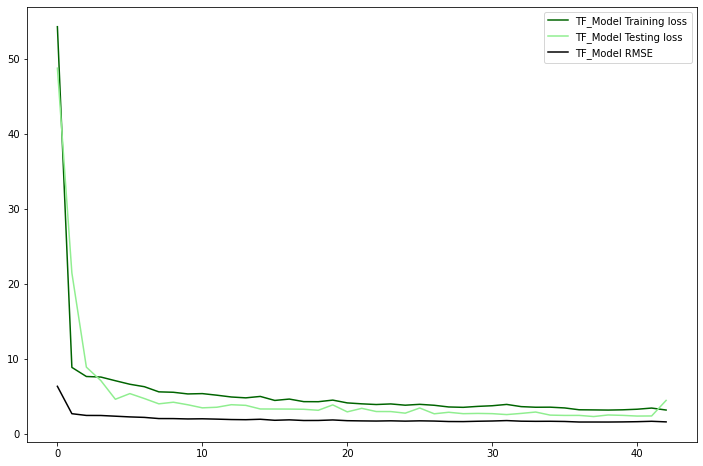

In [27]:
# Visualize loss
train_loss = results_es.history['loss']
test_loss = results_es.history['val_loss']
train_rmse = results_es.history['root_mean_squared_error']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='TF_Model Training loss', color='darkgreen')
plt.plot(test_loss, label='TF_Model Testing loss', color='lightgreen')
plt.plot(train_rmse, label='TF_Model RMSE', color='Black')

plt.legend();